In [41]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt

In [42]:
data = pf.open("Combined_DES_images_catalog.fits")

In [43]:
image = data[0].data
for i in range(0,len(image)):
    small = image[i]
    search = np.where(small<=0)
    search_2 = np.where(small>0)
    small[search] = np.min(small[search_2])
    image[i]=small

flat_image = np.log10(image.reshape(2862,2500))
origin_image = image.reshape(2862,2500)

labels = data[1].data['spiral']


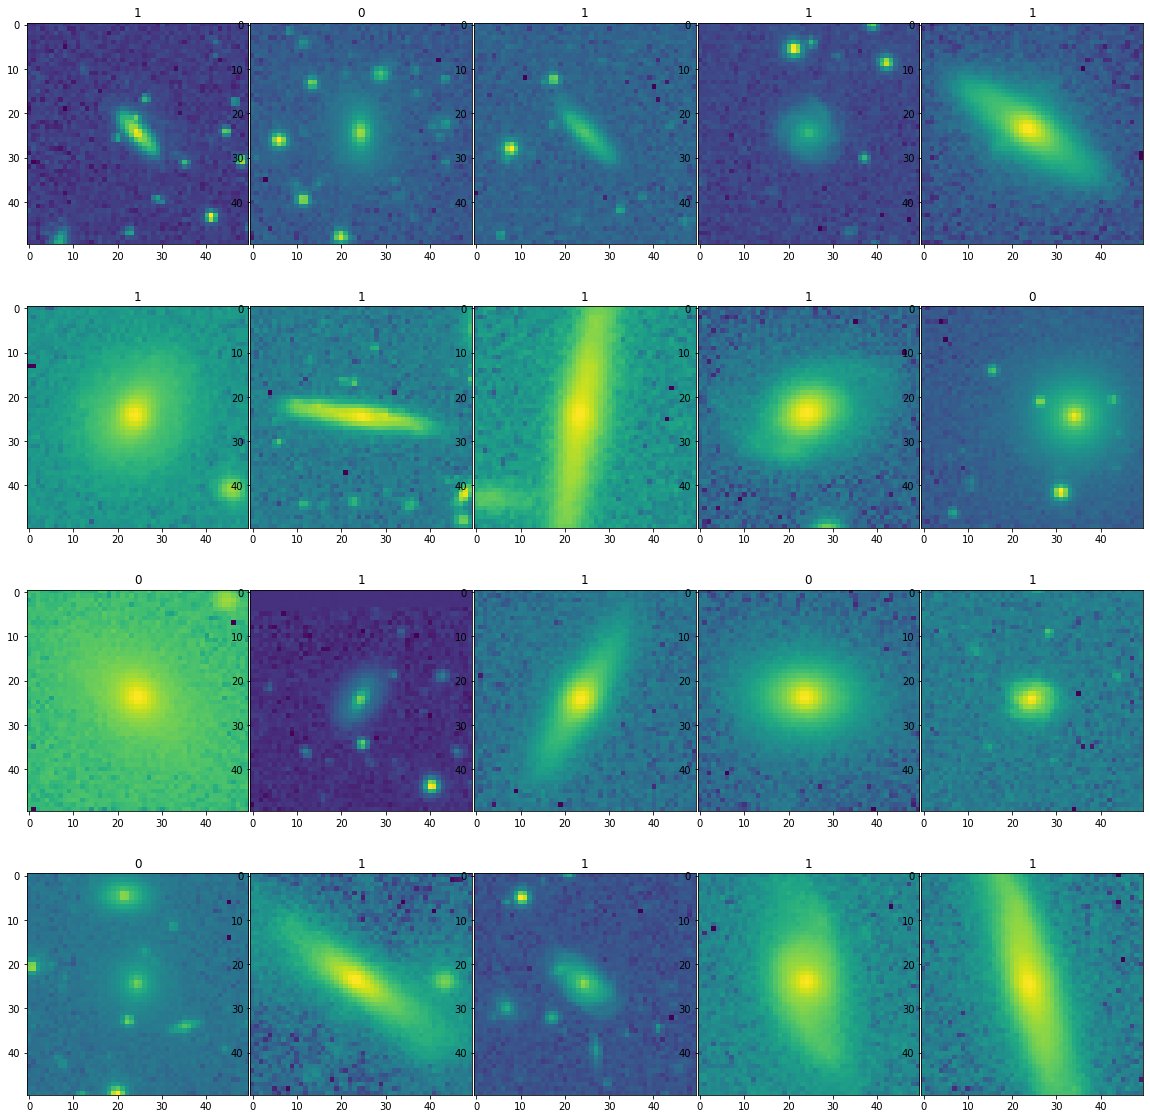

In [44]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.01)
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.imshow(flat_image[i].reshape(50,50))
    plt.title(labels[i])


In [47]:
import torch
import torch.nn.functional as F
class fully_connected_NN(torch.nn.Module):
    def __init__(self):
        super(fully_connected_NN, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(2500, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU())

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU())
        
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU())        
            
        self.fc4 = torch.nn.Sequential(
            torch.nn.Linear(100, 2),
            )
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        out = x
        return out

In [48]:
image_all = torch.from_numpy(np.array(origin_image,dtype=np.float32))
image_labels_all = np.zeros((len(labels),2))
for i in range(0,len(image_labels_all)):
    image_labels_all[i,labels[i]]=1

image_labels_all = torch.from_numpy(image_labels_all)

'''Using 0-2300 as the training set'''
image_train = image_all[0:2300]
image_labels = image_labels_all[0:2300,:]

'''Using 2300-2862 as the test set'''
test_labels = image_labels_all[2300:]
image_test = image_all[2300:,:]

In [49]:
model = fully_connected_NN()

In [50]:
learningRate = 0.1
epochs = 1500
criterion = torch.nn.CrossEntropyLoss()
# Just the loss function : here we use the default CrossEntropy()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [51]:
accuracy_array = []
accuracy_test_array = []
loss_array = []
loss_test_array = []
epoch_array = []

for epoch in range(epochs):
    model.train()
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    
    outputs = model(image_train)
    
    # get loss for the predicted output
    loss = criterion(outputs, image_labels)
    #print(loss)
    # get gradients w.r.t to parameters
    loss.backward()
    # update parameters
    optimizer.step()
    model.eval()
    with torch.no_grad():
        outputs_all = model(image_train)
        pred_y = torch.max(outputs_all, 1)[1].data.squeeze()
        accuracy = torch.sum((pred_y == torch.max(image_labels, 1)[1].data.squeeze()) / pred_y.size(0))
        #if epoch % 50 ==0:
        #    print(epoch,accuracy,loss)

        epoch_array.append(epoch)

        loss_array.append(float(loss.detach().numpy()))
        accuracy_array.append(float(accuracy.numpy()))


        outputs_test = model(image_test) 
        loss_test = criterion(outputs_test, test_labels)

        pred_y_test = torch.max(outputs_test, 1)[1].data.squeeze()
        accuracy_test = torch.sum((pred_y_test == torch.max(test_labels, 1)[1].data.squeeze()) / pred_y_test.size(0))
        accuracy_test_array.append(float(accuracy_test.numpy()))
        loss_test_array.append(float(loss_test.detach().numpy()))

    if epoch % 50 ==0:
        print(epoch,accuracy.numpy(),loss.detach().numpy(), accuracy_test.numpy(),loss_test.detach().numpy())

0 0.7373914 0.6731804377132136 0.72419924 0.6524585709240938
50 0.88130456 0.21535576231612288 0.8167259 0.4274887880137871
100 0.93521756 0.1150385409043234 0.8185052 0.4088851063940712
150 0.93869585 0.05663966449392638 0.78825617 0.6037911979627945
200 0.94913065 0.03864642390128023 0.76156574 0.6815934976200783
250 0.95260894 0.043732673412262855 0.8131672 0.477609102620241
300 0.77956533 0.23439053055121967 0.72064054 1.3605597087905543
350 0.9791306 0.02341336525859207 0.827402 0.5177790313534582
400 0.8313045 0.0688037667945267 0.72419924 0.8381464859159544
450 0.984348 0.01735148565883316 0.80960846 0.652714443192047
500 0.9991306 0.007385392102342788 0.827402 0.6847544497419523
550 0.99956536 0.004774534320057146 0.82028466 0.7262558239500444
600 1.0000001 0.003259824806475424 0.8167259 0.7654936470043189
650 1.0000001 0.002412745852298315 0.81138784 0.7991537548612933
700 1.0000001 0.0018874332206426049 0.8149466 0.8247876240922143
750 1.0000001 0.0013874999330007892 0.816725

(0.7, 1.0)

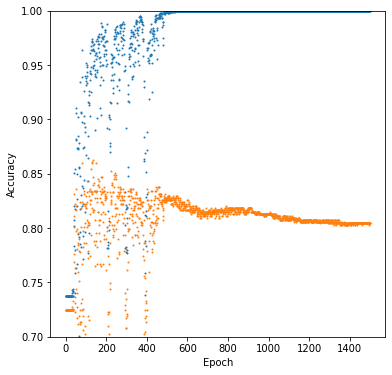

In [52]:
plt.figure(figsize=(6,6))
plt.scatter(epoch_array,accuracy_array,s=1)
plt.scatter(epoch_array,accuracy_test_array,s=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7,1)